# Telecom Churn

#### Business Goals
Identify customers at high risk of churn and identify the main indicators of churn.

#### Modelling Goals
Build models to predict churn. The predictive model that you’re going to build will serve two purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

imp - some of the code source (particularly the girdsearchcv) might take more then an hour to run .

### Imports and Data Sourcing

In [5]:
#imports
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from xgboost import plot_importance
#

#sourcing
df = pd.read_csv('telecom_churn_data.csv')
#

#configs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#

### Data Cleaning And Analysis

In [6]:
# total missing values
print("total missing values >",df.isna().sum(axis=1).sum())
#

display(df.shape)

total missing values > 3594931


(99999, 226)

### Deriving Features

1. Calculating total data recharge amount 

In [7]:
columns = filter(lambda x: 'rech' in x, df.columns )

df['total_rech_amt_data_6'] = df['av_rech_amt_data_6'] * df['total_rech_data_6']
df['total_rech_amt_data_7'] = df['av_rech_amt_data_7'] * df['total_rech_data_7']
df['total_rech_amt_data_8'] = df['av_rech_amt_data_8'] * df['total_rech_data_8']
df['total_rech_amt_data_9'] = df['av_rech_amt_data_9'] * df['total_rech_data_9']

# on inspection of these values none of the value are zero , which means that missing value here represents individuals not  
df['total_rech_amt_data_6'].fillna(0, inplace=True)
df['total_rech_amt_data_7'].fillna(0, inplace=True)
df['total_rech_amt_data_8'].fillna(0, inplace=True)
df['total_rech_amt_data_9'].fillna(0, inplace=True)

2. Breaking columns with numerical prefixes 6,7,8,9 into corresponding churn phase 
    1. 6,7  good 
    2. 8-> action 
    3. 9-> churn 

In [8]:
# getting all columns 
columns = filter(lambda x: x.split('_')[-1] == '6', df.columns )

# iterating over all 6 values
for column in columns:
    column_pattern = column.replace('6','')
    column_6 = column
    column_7 = column_pattern + '7'
    column_8 = column_pattern + '8'
    column_9 = column_pattern + '9'
    
    if is_numeric_dtype(df[column_6]):
        
        
        df[column_pattern + 'good'] = df[column_6] + df[column_7]
        df[column_pattern + 'action' ] = df[column_8]
        df[column_pattern + 'churn' ] = df[column_9]
        
    
        df.drop([column_6, column_7, column_8, column_9], inplace=True, axis=1)



2. Total Recharge cost
total_rech_amt_data_ is the cost of data recharge plans and total_rech_amt_ is the cost of call rechaege plans . Adding this should give us the total recharge amount

In [9]:
df['total_rech_amt_call_and_data_good'] =  df['total_rech_amt_good'] + df['total_rech_amt_data_good']
#df.drop(columns, inplace=True, axis=1)

3. Dropping amt based features so as to remove their influence over the final predictions . The idea is to calculate chrun based on usage. We will be dropping the columns later when high values customers are figured out.

In [10]:
price_columns_to_drop = filter(lambda x: 'amt' in x, df.columns )

### Filter high-value customers
Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase). We will try all of these options and see the shape after each operation .
1. This is achieved by carrying out the above mention operation on derived field total_rech_amt_call_and_data_good which is the total recharge in the good phase that a person carries out .

In [11]:
# recharge columns in the good phase
quantiles = df.loc[:, ['total_rech_amt_call_and_data_good']].quantile(q=0.70)

# removing values which are less than 70th percentile in total recharge amount
df = df.loc[(df['total_rech_amt_call_and_data_good'] >= quantiles['total_rech_amt_call_and_data_good']),:]


display(df.head())

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,arpu_good,arpu_action,arpu_churn,onnet_mou_good,onnet_mou_action,onnet_mou_churn,offnet_mou_good,offnet_mou_action,offnet_mou_churn,roam_ic_mou_good,roam_ic_mou_action,roam_ic_mou_churn,roam_og_mou_good,roam_og_mou_action,roam_og_mou_churn,loc_og_t2t_mou_good,loc_og_t2t_mou_action,loc_og_t2t_mou_churn,loc_og_t2m_mou_good,loc_og_t2m_mou_action,loc_og_t2m_mou_churn,loc_og_t2f_mou_good,loc_og_t2f_mou_action,loc_og_t2f_mou_churn,loc_og_t2c_mou_good,loc_og_t2c_mou_action,loc_og_t2c_mou_churn,loc_og_mou_good,loc_og_mou_action,loc_og_mou_churn,std_og_t2t_mou_good,std_og_t2t_mou_action,std_og_t2t_mou_churn,std_og_t2m_mou_good,std_og_t2m_mou_action,std_og_t2m_mou_churn,std_og_t2f_mou_good,std_og_t2f_mou_action,std_og_t2f_mou_churn,std_og_t2c_mou_good,std_og_t2c_mou_action,std_og_t2c_mou_churn,std_og_mou_good,std_og_mou_action,std_og_mou_churn,isd_og_mou_good,isd_og_mou_action,isd_og_mou_churn,spl_og_mou_good,spl_og_mou_action,spl_og_mou_churn,og_others_good,og_others_action,og_others_churn,total_og_mou_good,total_og_mou_action,total_og_mou_churn,loc_ic_t2t_mou_good,loc_ic_t2t_mou_action,loc_ic_t2t_mou_churn,loc_ic_t2m_mou_good,loc_ic_t2m_mou_action,loc_ic_t2m_mou_churn,loc_ic_t2f_mou_good,loc_ic_t2f_mou_action,loc_ic_t2f_mou_churn,loc_ic_mou_good,loc_ic_mou_action,loc_ic_mou_churn,std_ic_t2t_mou_good,std_ic_t2t_mou_action,std_ic_t2t_mou_churn,std_ic_t2m_mou_good,std_ic_t2m_mou_action,std_ic_t2m_mou_churn,std_ic_t2f_mou_good,std_ic_t2f_mou_action,std_ic_t2f_mou_churn,std_ic_t2o_mou_good,std_ic_t2o_mou_action,std_ic_t2o_mou_churn,std_ic_mou_good,std_ic_mou_action,std_ic_mou_churn,total_ic_mou_good,total_ic_mou_action,total_ic_mou_churn,spl_ic_mou_good,spl_ic_mou_action,spl_ic_mou_churn,isd_ic_mou_good,isd_ic_mou_action,isd_ic_mou_churn,ic_others_good,ic_others_action,ic_others_churn,total_rech_num_good,total_rech_num_action,total_rech_num_churn,total_rech_amt_good,total_rech_amt_action,total_rech_amt_churn,max_rech_amt_good,max_rech_amt_action,max_rech_amt_churn,last_day_rch_amt_good,last_day_rch_amt_action,last_day_rch_amt_churn,total_rech_data_good,total_rech_data_action,total_rech_data_churn,max_rech_data_good,max_rech_data_action,max_rech_data_churn,count_rech_2g_good,count_rech_2g_action,count_rech_2g_churn,count_rech_3g_good,count_rech_3g_action,count_rech_3g_churn,av_rech_amt_data_good,av_rech_amt_data_action,av_rech_amt_data_churn,vol_2g_mb_good,vol_2g_mb_action,vol_2g_mb_churn,vol_3g_mb_good,vol_3g_mb_action,vol_3g_mb_churn,arpu_3g_good,arpu_3g_action,arpu_3g_churn,arpu_2g_good,arpu_2g_action,arpu_2g_churn,night_pck_user_good,night_pck_user_action,night_pck_user_churn,monthly_2g_good,monthly_2g_action,monthly_2g_churn,sachet_2g_good,sachet_2g_action,sachet_2g_churn,monthly_3g_good,monthly_3g_action,monthly_3g_churn,sachet_3g_good,sachet_3g_action,sachet_3g_churn,fb_user_good,fb_user_action,fb_user_churn,total_rech_amt_data_good,total_rech_amt_data_action,total_rech_amt_data_churn,total_rech_amt_call_and_data_good
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN,968,30.40,0.00,101.20,3.58,412.201,213.803,21.100,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,0.00,0.00,0.00,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,0.00,5.44,0.00,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,7,2,6,614,252,0,504,252,0,504,252,0,2.0,1.0,NaN,504.0,252.0

### Tag churners and remove attributes of the churn phase

Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 

In [12]:
# tagging churners
df['churned'] = False

df.loc[df.apply(
    lambda x: (x['total_ic_mou_churn'] == 0 or x['total_ic_mou_churn'] == np.nan) and
    (x['total_og_mou_churn'] == 0 or x['total_og_mou_churn'] == np.nan) and
    (x['vol_2g_mb_churn'] == 0 or x['vol_2g_mb_churn'] == np.nan) and
    (x['vol_3g_mb_churn'] == 0 or x['vol_3g_mb_churn'] == np.nan) ,  axis=1 ),['churned'] ]= True


#droppping columns with 9 as suffix
columns = list(filter(lambda x: x.split('_')[-1] == 'churn', df.columns ))
df.drop(columns, axis=1, inplace=True)






### Filtering Columns and Handling Missing Values
1. Since the analysis is to be done on usage based , dropping amt based columns is required so as to remove it's effect in model creation process . The drop will occur at the end of all pre processing

In [13]:
price_columns_to_drop = filter(lambda x: 'amt' in x, df.columns )
#df.drop(list(price_columns_to_drop), axis=1, inplace=True)

1. Dropping columns where all the values are same

In [14]:
df.drop(list(df.loc[0,df.nunique(dropna=False) ==1].index.values), inplace=True, axis=1)

2. Finding columns where total_rech_amt_data_good i.e data recharge is 0 and filling out 0 inplace of NaN for values related to data packs.

In [15]:
# computation for good phase

data_related_columns = list(filter(lambda x: ('3g' in x or '2g' in x or 'vol' in x) 
                              and ('vbc' not in x)
                                and ('good' in x)
                              , df.columns ))

df.loc[(df['total_rech_amt_data_good'] == 0), data_related_columns] = 0

print(data_related_columns)

# computation for action phase

data_related_columns = list(filter(lambda x: ('3g' in x or '2g' in x or 'vol' in x) 
                              and ('vbc' not in x)
                                and ('action' in x)
                              , df.columns ))

df.loc[(df['total_rech_amt_data_action'] == 0), data_related_columns] = 0

print(data_related_columns)



['count_rech_2g_good', 'count_rech_3g_good', 'vol_2g_mb_good', 'vol_3g_mb_good', 'arpu_3g_good', 'arpu_2g_good', 'monthly_2g_good', 'sachet_2g_good', 'monthly_3g_good', 'sachet_3g_good']
['count_rech_2g_action', 'count_rech_3g_action', 'vol_2g_mb_action', 'vol_3g_mb_action', 'arpu_3g_action', 'arpu_2g_action', 'monthly_2g_action', 'sachet_2g_action', 'monthly_3g_action', 'sachet_3g_action']


3. Checking columns with NA value. 
An observation that the missing value is same across some group of rows. We will be analyzing each of these values to see if we can impute missing value to each of these with either 0 or osome other value

In [16]:
columns_with_na_value = list(df.loc[:, df.isna().sum(axis=0) != 0 ].columns)

df_na = df.isna().sum()

missing_value_group = {}

for column in columns_with_na_value:
    
    value_counts = df_na[column]
    
    missing_value_group[value_counts] = missing_value_group.get(value_counts, []) + [column]
    
display(missing_value_group)

{224: ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou'],
 27: ['last_date_of_month_7'],
 165: ['last_date_of_month_8'],
 365: ['last_date_of_month_9'],
 73: ['date_of_last_rech_6'],
 98: ['date_of_last_rech_7'],
 583: ['date_of_last_rech_8'],
 815: ['date_of_last_rech_9'],
 13245: ['date_of_last_rech_data_6'],
 12944: ['date_of_last_rech_data_7'],
 14048: ['date_of_last_rech_data_8',
  'total_rech_data_action',
  'max_rech_data_action',
  'av_rech_amt_data_action',
  'night_pck_user_action',
  'fb_user_action'],
 14781: ['date_of_last_rech_data_9'],
 782: ['onnet_mou_good',
  'offnet_mou_good',
  'roam_ic_mou_good',
  'roam_og_mou_good',
  'loc_og_t2t_mou_good',
  'loc_og_t2m_mou_good',
  'loc_og_t2f_mou_good',
  'loc_og_t2c_mou_good',
  'loc_og_mou_good',
  'std_og_t2t_mou_good',
  'std_og_t2m_mou_good',
  'std_og_t2f_mou_good',
  'std_og_t2c_mou_good',
  'std_og_mou_good',
  'isd_og_mou_good',
  'spl_og_mou_good',
  'og_others_good',
  'loc_ic_t2t_mou_good',
  'loc_ic_t2m_mou_go

In [17]:
### analyzing call based rows

call_columns = list(filter(lambda x: ('ic' in x or 'og' in x )
                              , df.columns ))

#display(df[df.loc[:, missing_value_group[224]].isna().sum(axis=1) > 0].loc[:, call_columns])


 imputing 0 in call based rows when ic and og total are zero

In [18]:
df.loc[(df['total_ic_mou_good'] 
        + df['total_ic_mou_action'] 
       + df['total_og_mou_good']  + df['total_og_mou_action'] == 0  ), call_columns] = 0

 'count_rech_2g_good', 'count_rech_3g_good', 'arpu_3g_good', 'arpu_2g_good', 'total_rech_data_action', 'max_rech_data_action', 'av_rech_amt_data_action', 'night_pck_user_action', 'fb_user_action', 'total_rech_data_good', 'max_rech_data_good', 'av_rech_amt_data_good', 'night_pck_user_good', 'fb_user_good' are being dropped since `they are not usage related and contain a lot of missing values`
   


In [19]:
df.drop(missing_value_group[5187] + missing_value_group[14048] + missing_value_group[15688] , axis=1, inplace=True)

Since the analysis is to be done on usage , we will be removing all date based columns , aon and vbc .

In [20]:
date_columns = list(filter(lambda x: ('date' in x or 'aon' in x or 'vbc' in x)
                              , df.columns ))

df.drop(date_columns, axis=1, inplace=True)

checking again to see if any column has same value and dropping them

In [21]:
df.drop(list(df.loc[0,df.nunique() == 1].index.values), inplace=True, axis=1)

### Filtering Rows

1. Dropping rows with missing values
2. Changing index to phone number

In [22]:
df = df.loc[df.isna().sum(axis=1) == 0]

In [23]:
df.set_index('mobile_number', inplace=True)

### Univariate Analysis

#### Churn Rate

churn percent -> 5.6


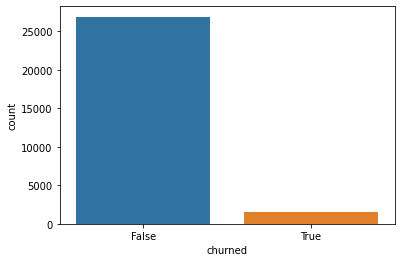

In [24]:
plt_temp = sns.countplot(x = 'churned', data=df)
print("churn percent ->", round((df['churned'] == True).sum()/(float(df.shape[0])) * 100, 2))

#### Revenue Analysis

<AxesSubplot:>

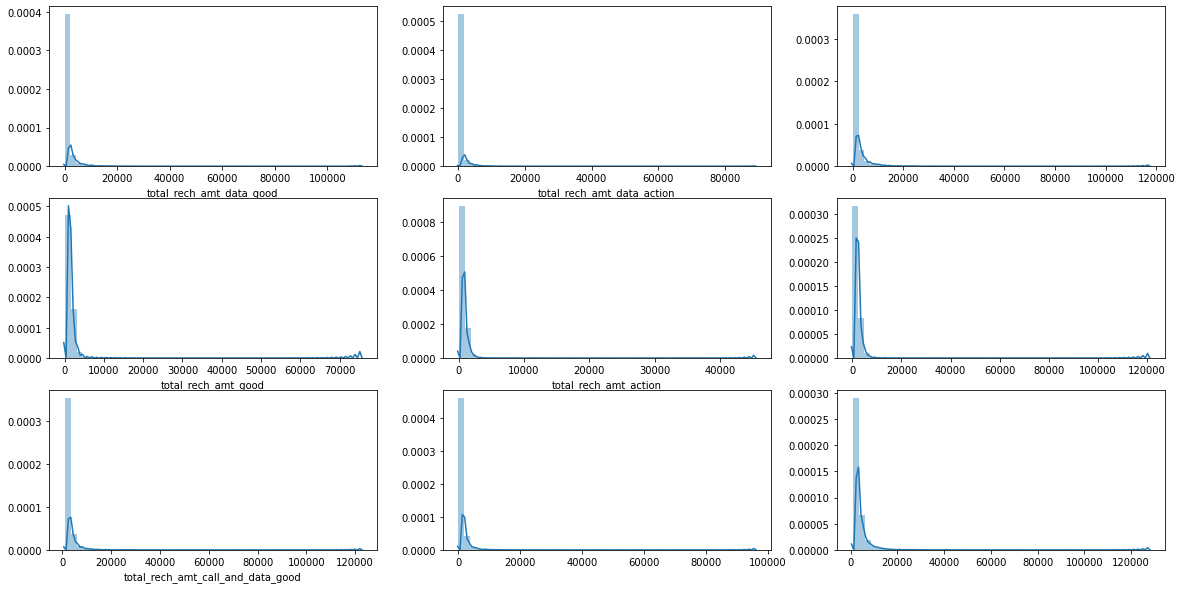

In [25]:
fig, axes = plt.subplots(3,3, figsize=(20,10))

# plotting rech amt on data 
sns.distplot(df['total_rech_amt_data_good'], ax=axes[0,0])
sns.distplot(df['total_rech_amt_data_action'], ax=axes[0,1])
sns.distplot(df['total_rech_amt_data_action'] + df['total_rech_amt_data_good'], ax=axes[0,2])


# plotting rech amt on call
sns.distplot(df['total_rech_amt_good'], ax=axes[1,0])
sns.distplot(df['total_rech_amt_action'], ax=axes[1,1])
sns.distplot(df['total_rech_amt_action'] + df['total_rech_amt_good'], ax=axes[1,2])


# plotting rech amt on total recharge size
sns.distplot(df['total_rech_amt_call_and_data_good'], ax=axes[2,0])
sns.distplot(df['total_rech_amt_action'] + df['total_rech_amt_data_action'], ax=axes[2,1])
sns.distplot(df['total_rech_amt_call_and_data_good'] + df['total_rech_amt_action'] + df['total_rech_amt_data_action'], ax=axes[2,2])




In the above plot , first row is for data recharge each in good , action phase . The final column is sum of prices of data recharge both in good and action phase. Similary second one denotes for call data with rows similar to that of the first column . The final row is generated by summing first two rows that means the total recharge commited by each user . The distplot here shows the consistency in distribution of user along various recharge segments . 

#### Bivariate/Multivariate Analysis

Analyzing all ic and og calls for both good and action phase . We start by planting a bsic logistic regression plot across each individual variable . `imp : it did not give any benificial result.The code to plot logistic regression is commented`

In [26]:
ic_mou_good = list(filter(lambda x: ('ic' in x   and 'mou' in x), df.columns ))
og_mou_good = list(filter(lambda x: ('og' in x  and 'mou' in x), df.columns ))


# logistic  regression plot for individual varibale
# for predictor_index in range(0, len(ic_mou_good)):
    
#     #sns.lmplot(x=ic_mou_good[predictor_index], y="churned", data=df,
#               # y_jitter=.02, logistic=True, truncate=False)
    
#     nunique = df[ic_mou_good[predictor_index]].nunique()
    
#     print(nunique)
    
#     if nunique > 1:
        
#         plt.subplot(14, 2, 1)
#         sns.lmplot(x=ic_mou_good[predictor_index], y="churned", data=df,
#                y_jitter=.02, logistic=True, truncate=False)

# fig, axes = plt.subplots(14,2, figsize=(50,150))

# for foo in range(0, len(ic_mou_good)) :
    
#     sns.boxplot(y=ic_mou_good[foo], x="churned", data=df, ax=axes[foo,0])
    
    
df.loc[:,ic_mou_good + og_mou_good].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
roam_ic_mou_good,28504.0,27.498316,121.958160,0.0,0.0000,0.000,3.0600,5546.39
roam_ic_mou_action,28504.0,12.262867,71.298014,0.0,0.0000,0.000,0.0000,4169.81
loc_ic_t2t_mou_good,28504.0,136.318770,318.202564,0.0,19.3875,58.030,142.0550,11432.32
loc_ic_t2t_mou_action,28504.0,65.744125,162.379568,0.0,6.6400,25.140,68.4100,4003.21
loc_ic_t2m_mou_good,28504.0,311.649598,416.607600,0.0,76.0675,184.960,389.8325,8865.37
loc_ic_t2m_mou_action,28504.0,153.459888,217.880439,0.0,30.4800,87.060,193.1950,4643.49
loc_ic_t2f_mou_good,28504.0,32.429199,90.356548,0.0,0.5100,5.840,27.1925,2716.87
loc_ic_t2f_mou_action,28504.0,15.112914,44.277045,0.0,0.0000,2.080,12.1650,1588.53
loc_ic_mou_good,28504.0,480.417479,604.614898,0.0,124.3150,294.870,613.0075,13113.34
loc_ic_mou_action,28504.0,234.326705,312.168478,0.0,50.2550,139.290,297.3775,5388.74


plotting total ic and outgoing calls with average revenue per customer and churn

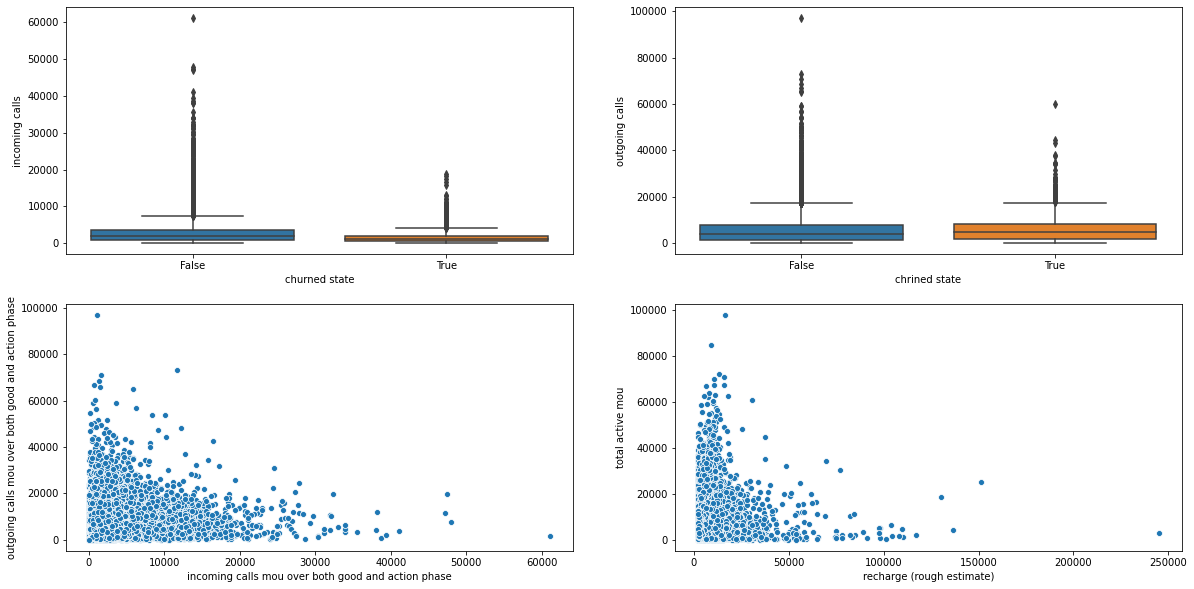

In [27]:
incoming = df.loc[:,ic_mou_good].sum(axis=1)
outgoing = df.loc[:,og_mou_good].sum(axis=1)


fig, axes = plt.subplots(2,2, figsize=(20,10))

# plotting rech amt on data 
ax2 = sns.boxplot(x=df['churned'], y=incoming, ax=axes[0,0])
ax3 = sns.boxplot(x=df['churned'], y=outgoing, ax=axes[0,1])

ax2.set(xlabel='churned state', ylabel='incoming calls')
ax3.set(xlabel='chrined state', ylabel='outgoing calls')

# plotting scatter plot

ax1 = sns.scatterplot(y=outgoing , x=incoming, ax=axes[1,0])
ax1.set(xlabel='incoming calls mou over both good and action phase', ylabel='outgoing calls mou over both good and action phase')

ax4 = sns.scatterplot(y=outgoing + incoming , x=df['total_rech_amt_call_and_data_good'] + df['total_rech_amt_call_and_data_good'], ax=axes[1,1])
ax4.set(ylabel='total active mou', xlabel='recharge (rough estimate)')

plt.show()



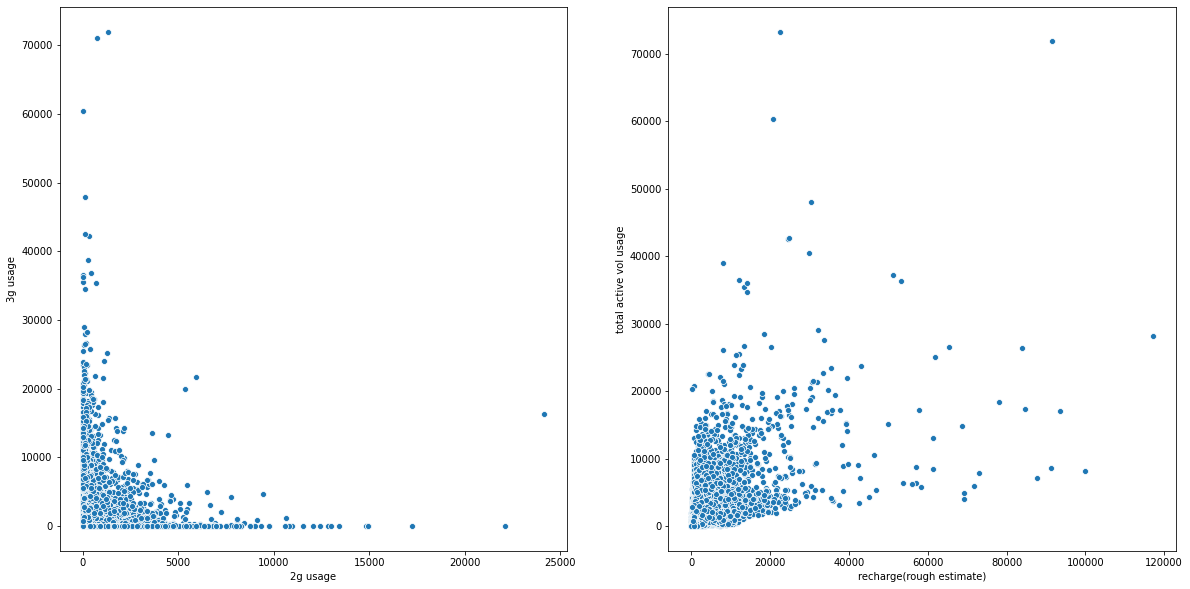

In [28]:
vol_usage_2g_columns = list(filter(lambda x: ('vol' in x   and '2g' in x), df.columns ))

vol_usage_3g_columns = list(filter(lambda x: ('vol' in x   and '3g' in x), df.columns ))

_3g_usage = df.loc[:,vol_usage_3g_columns].sum(axis=1)
_2g_usage = df.loc[:,vol_usage_2g_columns].sum(axis=1)


fig, axes = plt.subplots(1,2, figsize=(20,10))

# plotting rech amt on data 
# ax2 = sns.boxplot(x=df['churned'], y=_3g_usage, ax=axes[0,0])
# ax3 = sns.boxplot(x=df['churned'], y=_2g_usage, ax=axes[0,1])

# ax2.set(xlabel='churned state', ylabel='3g usage')
# ax3.set(xlabel='chrined state', ylabel='2g usage')

# plotting scatter plot

ax1 = sns.scatterplot(y=_3g_usage , x=_2g_usage, ax=axes[0])
ax1.set(xlabel='2g usage', ylabel='3g usage')

ax4 = sns.scatterplot(y=_3g_usage + _2g_usage , x=df['total_rech_amt_data_good'] + df['total_rech_amt_data_action'], ax=axes[1])
ax4.set(ylabel='total active vol usage', xlabel='recharge(rough estimate)')

plt.show()

Not a lot of detail is directly available from plotting bivariate analysis of vol and mou . A corrleation table should help us provide predictors realted to each other . One analysis common to all observation is the skewness of data towards left side for data vol , call mou and pricing . Before we proceed further (for plotting and modelling) , `dropping revenue based columns` .

In [29]:
price_columns_to_drop = filter(lambda x: 'amt' in x or 'arpu' in x, df.columns )
df.drop(price_columns_to_drop, axis=1, inplace=True)

<AxesSubplot:>

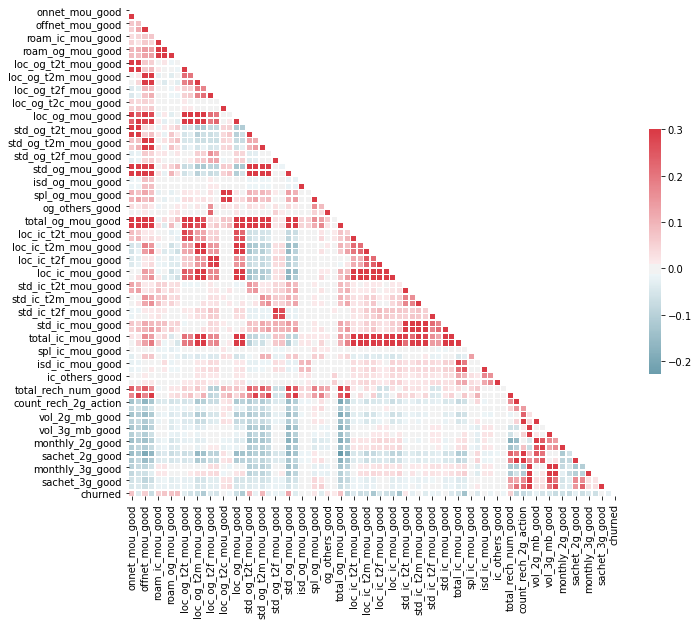

In [30]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A strong correlation (>= 0.5 or <= -0.5) is not visible , hence we should move on to component analysis tecnhiques to transform source and basis for better results 

## Modelling and Analysis

We have a case of class imbalance over here , since the churn class (the main class) is low . `We can solve this using over sampling and under sampling` . To find the ideal model , we will be running a pipelined operation over multiple sampling techniques and models to get to a final model. 



In [31]:
y = df['churned'].copy()
X = df.drop(['churned'], axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

gauss_vars = []
not_gauss_vars = []

### checking if standard s
for variable in X_train.columns:
    
    stat, p = shapiro(df[variable])
    
    alpha = 0.05
    
    if p > alpha:
        
        gauss_vars.append(variable)
        
    else:
        
        not_gauss_vars.append(variable)
        
## apply Standarization to gaussian variables

if len(gauss_vars) > 0:
    scaler = StandardScaler()
    scaler.fit(X_train.loc[:, gauss_vars])
    X_train.loc[:, gauss_vars] = scaler.transform(X_train.loc[:, gauss_vars])
    X_test.loc[:, gauss_vars] = scaler.transform(X_test.loc[:, gauss_vars])

## apply MinMaxScaling to non gaussian variables
scaler = MinMaxScaler()
scaler.fit(X_train.loc[:, not_gauss_vars])
X_train.loc[:, not_gauss_vars] = scaler.transform(X_train.loc[:, not_gauss_vars])
X_test.loc[:, not_gauss_vars] = scaler.transform(X_test.loc[:, not_gauss_vars])

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Predict customers who will churn
#### How do we plan to solve this problem
1. A config file will be created for each set of subproblem - sampling , pca , models
2. Each entry in each config file is independent of each other i.e the total number of iterations with hyperparamter tuning will be len(sampling) * len(pca) * len(models)
3. This processing will take a lot of time but we will have combined result of multiple algorithms with minimal code 
4. `Since our main goal` is to predict wether a `high value customer` `churns or not`, our focus would be more on `recall` as compared to precision or accuracy . Recall will tell us home many churned customer out of all `the actual churned customer did we predict correct`. But we would want to avoid predicting too many non churned customers as churned . Hence to avoid that in an imbalanced class we can look towards `Matthews Correlation Coefficient` where a value of 0 means a random outcome , value towards -1 means that the prediction is going incorrect and 1 means a perfect prediction . More can be read about the algorithm here - https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html . Our refit on GridSearchCV works on Matthews Correlation Coefficient.


### Importat Note - Since all these operate independently with no memoization , the cost to run maybe more than an hour . 
sampling config has a commented smote config , do uncomment it before running the full analysis (it takes 30 min for full analysis). Incase  quick analysis is what the runner is intendiing , leave it as it is , it should take 10-15 min apprx for complete analysis.


#### 1. Sampling Techinques
We will be using oversampling (SMOTE) , undersampling (RUS)

In [53]:
sampling_config = {
    #oversampling , adding data to minority class
    # uncomment below line for complete analysis , 
    'SMOTE': {'model': SMOTE(), 'config': {
            'sampling_strategy': ['minority'],
            'k_neighbors' : range(5, 6)
    }},
    # undersampling , adding data to majority class
    'RUS': {'model': RandomUnderSampler(), 'config': {
        'sampling_strategy': ['majority']
    }}
}

#### 2. PCA
1. First we will draw  
    1. variance vs number of components plot
    2. variance sum vs num of components plot
2. Then we create a PCA config file

found 90% explained variance using 20 components


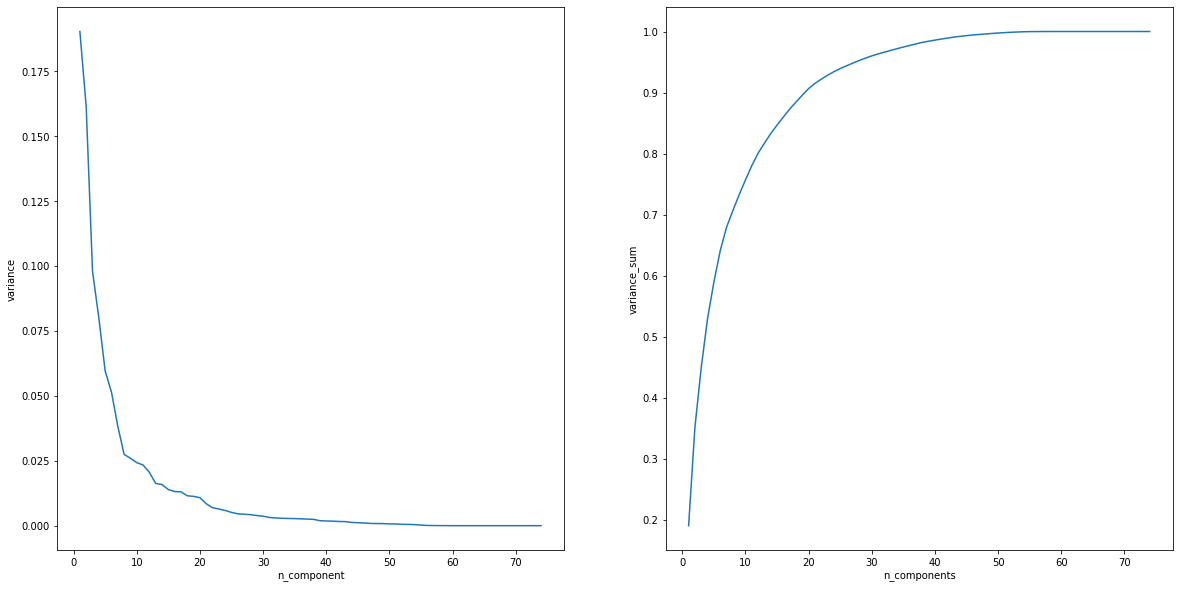

In [54]:
pca = IncrementalPCA()

pca_train = pca.fit_transform(X_train, y_train)

fig, axes = plt.subplots(1,2, figsize=(20,10))

ax = sns.lineplot(x=range(1, len(pca.explained_variance_) + 1), y=pca.explained_variance_ratio_, ax=axes[0])
ax.set(xlabel='n_component', ylabel='variance')
ax.plot()

ax1 = sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1),
                  y= [sum(pca.explained_variance_ratio_[0:x+1]) for x in range(0,len(pca.explained_variance_ratio_))], ax=axes[1])

ax1.set(xlabel='n_components', ylabel='variance_sum')

for variance_ratio_sum, index in zip(
    [sum(pca.explained_variance_ratio_[0:x+1]) for x in range(0,len(pca.explained_variance_ratio_))],
    range(1, len(pca.explained_variance_ratio_) + 1)
    ):
    
    if variance_ratio_sum >= 0.9:
        print("found 90% explained variance using " + str(index) + " components")
        break


We get 90% of the explained variance at about 20 components . Creating the pca config file. Creating the PCA config file.

In [55]:
pca_config = {
    'IPCA': {
        'model': IncrementalPCA(),
        'config': {
            'n_components': range(20, 21)
        }
        
    }
}

#### 3. Models
We will be running a list of model and analyzing their performance using CV and recall.

In [56]:
model_config = {
    'ADA_Decision': {
        'model': AdaBoostClassifier(random_state=100),
        'config': {
            'n_estimators': range(1000, 2000, 200)
        }
    },
    'Logistic': {
        'model': LogisticRegression(random_state=100, solver='saga'),
        'config':{}
    },
    "XGBClassifier": {
        'model': xgb.XGBClassifier(),
        'config': {
            'nthread': [4],
            'objective': ['binary:logistic'],
            'learning_rate': [0.01],
            'max_depth': range(2, 5, 2),
            'subsample': [1],
            'n_estimators': range(1000, 2000, 200)
        }
    },
    "RandomForest": {
        'model': RandomForestClassifier(random_state=100),
        'config': {
            'max_depth': range(2, 10, 2),
            'n_estimators': range(1000, 2000, 200)
        }
    }
    
    
}

Iterating over all config (sampling , pca, model_config) 

In [57]:
#lz = None

results = []

# iterates over multiple model config
def model_iterator(sampling_config, pca_config, X=X_train, y=y_train):
    
    for sampling in sampling_config:
        
        pipeline = []
        
        params = {}
        
        # adding sampling method
        
        pipeline.append(
            ('sampling', sampling_config[sampling]['model']),
        )
        
        # applying parameters
        
        for param in sampling_config[sampling]['config']:
            
            params['sampling__' + param] = sampling_config[sampling]['config'][param]
        
        
        # dimenstionality reduction with PCA
        
        for pca in pca_config:
            
            # applying pca
            
            pipeline.append(
                ('pca', pca_config[pca]['model']),
            )
            
            # applying paramters
            
            
            for param in pca_config[pca]['config']:
            
                params['pca__' + param] = pca_config[pca]['config'][param]
                
                
            #print(model_config)    
                
                # applying model
                
            for model in model_config:
                    
                pipeline_final = pipeline.copy()
                    
                params_final = params.copy()
                    
                pipeline_final.append(
                    ('model', model_config[model]['model']),
                )
                    
                    # applying paramter
                    
                    
                    
                    
                for param in model_config[model]['config']:
                        
                    params_final['model__' + param] = model_config[model]['config'][param]
                        
                        
                gsc = GridSearchCV(Pipeline(pipeline_final), 
                            param_grid=params_final, n_jobs=2,
                                   scoring={'f1': 'f1',
                                            'recall': 'recall',
                                            'mcc': make_scorer(matthews_corrcoef),
                                            'accuracy': 'accuracy',
                                            'roc_auc': 'roc_auc'
                                           },
                                  return_train_score=True,
                                   refit='mcc'
                                  )
                        
                gsc.fit(X, y)
                
                results.append(
                {
                    'model_name': sampling + '_' + model,
                    'results': gsc.cv_results_,
                    'params': params_final
                }
                )
                
                print(sampling + '_' + model)

        
        
model_iterator(sampling_config=sampling_config, pca_config=pca_config)

SMOTE_ADA_Decision
SMOTE_Logistic
SMOTE_XGBClassifier
SMOTE_RandomForest
RUS_ADA_Decision
RUS_Logistic
RUS_XGBClassifier
RUS_RandomForest


Creating a tabular result from our above experiment

In [58]:
df_result_analysis = pd.DataFrame(columns=list(results[0]['results'].keys()) + ['model_name'])

for result in results:
    
    model_name = result['model_name']
    
    
    df_temp = pd.DataFrame(result['results'])
    
    df_temp['model_name'] = model_name
    
    df_result_analysis = pd.concat([df_result_analysis, df_temp])
    

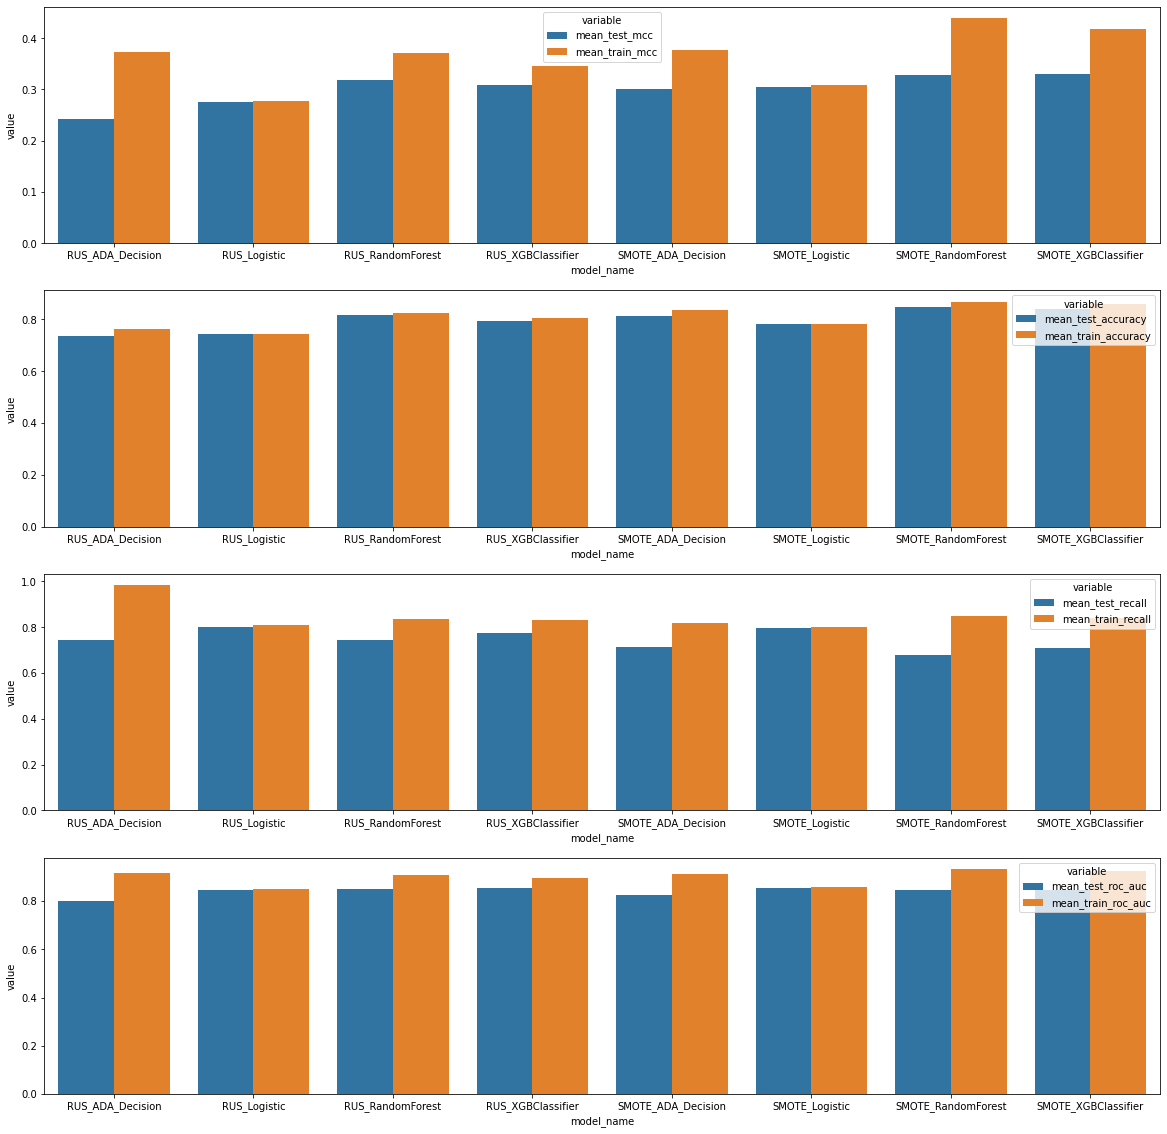

In [59]:

result = df_result_analysis.sort_values('mean_test_mcc', ascending=False).groupby('model_name').first()
result['model_name'] = list(result.index)


result_melted_train = pd.melt(result, value_vars=['mean_train_f1', 'mean_train_recall',
                                            'mean_train_mcc', 'mean_train_accuracy'], id_vars=['model_name', 'params'])


fig, axes = plt.subplots(4,1, figsize=(20,20))

index = 0

for assesment in ['mcc', 'accuracy', 'recall', 'roc_auc']:
    
    
    
    columns_to_melt = ['mean_test_' + assesment, 'mean_train_' + assesment]
    
    result_melted = pd.melt(result, 
                                 value_vars=columns_to_melt, id_vars=['model_name', 'params'])

    g1 = sns.barplot(x="model_name", y="value", hue="variable",
                  data=result_melted, ax=axes[index])
    
    index = index + 1



In [60]:
#result.sort_values('mean_test_mcc', ascending=False)
display(result.sort_values(['mean_test_recall'], ascending=False).loc[:, ['mean_test_mcc', 
                                                                     'mean_test_accuracy',
                                                                     'mean_test_recall', 
                                                                     'mean_test_roc_auc']])

,mean_test_mcc,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
model_name,,,,
RUS_Logistic,0.275210,0.743061,0.802800,0.846346
SMOTE_Logistic,0.304965,0.780336,0.795793,0.854466
RUS_XGBClassifier,0.308463,0.794282,0.773194,0.853503
RUS_ADA_Decision,0.242817,0.735824,0.743565,0.802073
RUS_RandomForest,0.318872,0.816823,0.742783,0.851561
SMOTE_ADA_Decision,0.300164,0.812042,0.714737,0.824844
SMOTE_XGBClassifier,0.330689,0.839671,0.708478,0.845935
SMOTE_RandomForest,0.327258,0.847301,0.679648,0.846230


`The goal` here is to predict to a model with comparatively `high mcc and  roc_auc` and a high recall . Two learners here seem to give the best result .
1. Logistic with Smote Sampling (better mcc and secong highest recall)
2. XGBClassifier with Smote Sampling (highest mcc and sub standard accuracy )

## Since our goal here is to predict recall better , we will focus on Logistic Regression for the final result . 

 Logistic Regression of learning algorithm can give us the required model (as per our analysis run above):
1. `Logistic Regression -> LogisticRegression with 'saga' as solver , l2 regularization and random state as 100`
2. PCA Components - `20`
3. SMOTE for subsampling with `k_neighbors 5`

In [66]:
# over sampling using SMOTE
sm = SMOTE(sampling_strategy='minority', k_neighbors=5)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
#

# pca : explains 90% of the variance
pca = IncrementalPCA(n_components=22)
X_train_smote_pca = pca.fit_transform(X_train_smote, y_train_smote)
X_test_smote_pca = pca.transform(X_test)
#

# random_state 100 and saga solver
logistic = LogisticRegression(random_state=100, solver='saga')
logistic.fit(X_train_smote_pca, y_train_smote)

# validation on train set
y_train_smote_pca_result = logistic.predict(X_train_smote_pca)

# creating confusion matrix
display(confusion_matrix(y_train_smote, y_train_smote_pca_result))

array([[16781,  4739],
       [ 3495, 18025]])

Important metric from above analysis on train set
1. Recall rate/Senstivity on train set is 83.38%
2. Specificity on train set is 77.88%

#### Performing the analysis on test set

In [67]:
# validation on test set
y_test_result = logistic.predict(X_test_smote_pca)

display(confusion_matrix(y_test, y_test_result))

array([[4176, 1212],
       [  66,  247]])

##### important metric from above analysis on test set
1. Recall Rate/Senstivity on test set is 78.91%
2. Specificity is 77.50%

## Identifying important predictor attributes

1. We will be taking the same approach as we did with Predicting Customer Churn minus the PCA part .
2. We will focus on tree based algorithm here , specifically decision tree and try to tune it's parameters 

#### 1. Sampling Techinques
We will be using oversampling (SMOTE) , undersampling (RUS)

In [34]:
sampling_config_no_pca = {
    # undersampling , adding data to majority class
    'RUS': {'model': RandomUnderSampler(), 'config': {
        'sampling_strategy': ['majority']
    }},
    
    #oversampling , adding data to minority class
    # uncomment below line for complete analysis , 
    'SMOTE': {'model': SMOTE(), 'config': {
            'sampling_strategy': ['minority'],
            'k_neighbors' : range(5, 6)
    }},
    
}

#### 2. Models

In [35]:
model_config_no_pca = {
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=100),
        'config':{
            'criterion': ['gini'],
            'splitter': ['best', 'random'],
            'max_depth': range(2, 10),
            'min_samples_split': range(2, 12, 4),
            'min_samples_leaf': range(2, 12, 4),
        }
    },
    "RandomForest": {
        'model': RandomForestClassifier(random_state=100),
        'config': {
            'max_depth': range(2, 10, 2),
            'n_estimators': [100, 200]
        }
    },
    "XGBClassifier": {
        'model': xgb.XGBClassifier(),
        'config': {
            'nthread': [4],
            'objective': ['binary:logistic'],
            'learning_rate': [0.01],
            'max_depth': range(2, 5, 2),
            'subsample': [1],
            'n_estimators': range(100, 1400, 400)
        }
    },
    
    
    
}


In [36]:
#lz = None

results = []

# iterates over multiple model config

for sampling in sampling_config_no_pca:
    
    pipeline = []
    
    params = {}
    
    # adding sampling technique to pipeline
    
    pipeline.append(
        ('sampling', sampling_config_no_pca[sampling]['model']),
    )
    
    # configuring pca
    
    for param in sampling_config_no_pca[sampling]['config']:
            
        params['sampling__' + param] = sampling_config_no_pca[sampling]['config'][param]
        
    # adding model to pipelline
    
    for model in model_config_no_pca:
                    
        pipeline_final = pipeline.copy()
                    
        params_final = params.copy()
                    
        pipeline_final.append(
            ('model', model_config_no_pca[model]['model']),
        )
        
        # param config
        
        for param in model_config_no_pca[model]['config']:
                        
            params_final['model__' + param] = model_config_no_pca[model]['config'][param]
        
        print("starting")
            
        gsc = GridSearchCV(Pipeline(pipeline_final), 
                        param_grid=params_final, n_jobs=-1,
                                scoring={'f1': 'f1',
                                        'recall': 'recall',
                                        'mcc': make_scorer(matthews_corrcoef),
                                        'accuracy': 'accuracy',
                                        'roc_auc': 'roc_auc'
                                        },
                        return_train_score=True,
                        refit='mcc'
                    )
        gsc.fit(X, y)
        
        
        results.append(
            {
                'model_name': sampling + '_' + model,
                'results': gsc.cv_results_,
                'params': params_final
            }
        )
                        
            
                
            
                
        print(sampling + '_' + model)
        


starting
RUS_DecisionTreeClassifier
starting
RUS_RandomForest
starting
RUS_XGBClassifier
starting
SMOTE_DecisionTreeClassifier
starting
SMOTE_RandomForest
starting
SMOTE_XGBClassifier


In [37]:
df_result_analysis = pd.DataFrame(columns=list(results[0]['results'].keys()) + ['model_name'])

for result in results:
    
    model_name = result['model_name']
    
    
    df_temp = pd.DataFrame(result['results'])
    
    df_temp['model_name'] = model_name
    
    df_result_analysis = pd.concat([df_result_analysis, df_temp])
    
result = df_result_analysis.sort_values('mean_test_recall', ascending=False).groupby('model_name').first()
result['model_name'] = list(result.index)

In [38]:
display(result.sort_values(['mean_test_mcc'], ascending=False).loc[:, ['mean_test_mcc', 
                                                                     'mean_test_accuracy',
                                                                     'mean_test_recall', 
                                                                     'mean_test_roc_auc']])

,mean_test_mcc,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
model_name,,,,
RUS_XGBClassifier,0.392677,0.854336,0.796356,0.893708
SMOTE_RandomForest,0.383618,0.877280,0.699861,0.866456
RUS_RandomForest,0.381577,0.858827,0.758764,0.885776
SMOTE_XGBClassifier,0.313440,0.823499,0.716174,0.833995
SMOTE_DecisionTreeClassifier,0.310777,0.816517,0.726191,0.793245
RUS_DecisionTreeClassifier,0.139027,0.497543,0.820243,0.665284


In [39]:
params = list(filter(lambda x: ('param' in x),  result))
display(result.loc[['RUS_XGBClassifier'], params].transpose())

model_name,RUS_XGBClassifier
param_model__criterion,NaN
param_model__max_depth,4
param_model__min_samples_leaf,NaN
param_model__min_samples_split,NaN
param_model__splitter,NaN
param_sampling__sampling_strategy,majority
params,"{'model__learning_rate': 0.01, 'model__max_dep..."
param_model__n_estimators,900
param_model__learning_rate,0.01
param_model__nthread,4


Among all the models ranked by mcc score , RUS_XGBClassifier has the highest recall score as well . Following were the params associated with it
1. UnderSampling with RUS
2. Classifying using XGBClassifier
3. param_model__max_depth - 4
4. param_model__n_estimators - 1300

We will be trying more depth and estimators to see if the results improve by a significant margin

In [40]:
# Rus undersampling
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
#

# Model fitting
gs = GridSearchCV(
    xgb.XGBClassifier(
    nthread=4,
    objective='binary:logistic',
    learning_rate=0.01,
    subsample=1
    ),
    param_grid={
        'max_depth': range(2, 12, 2),
        'subsample': [1, 0.8],
        'n_estimators': range(1400, 2001, 200),
    },
    n_jobs=-1,
    scoring={'f1': 'f1',
            'recall': 'recall',
            'mcc': make_scorer(matthews_corrcoef),
            'accuracy': 'accuracy',
            'roc_auc': 'roc_auc'
             },
    return_train_score=True,
    refit='mcc'
)

gs.fit(X_train_rus, y_train_rus)
#

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     scale_pos_weight=None, subsample=1,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 12, 2),
          

Displaying a summary result on the performance of various hyperparameter .

In [41]:
result = pd.DataFrame(gs.cv_results_).sort_values(['mean_test_mcc'], ascending=False)

In [42]:
params = list(filter(lambda x: ('param' in x),  result))
scores = ['mean_test_mcc', 'mean_test_accuracy','mean_test_recall', 'mean_test_roc_auc']
display(result.loc[[33],params + scores ].transpose())


# importance = tree.feature_importances_
# temp_columns = list(df.columns)
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0s, Score: %.5f' % (temp_columns[i],v))
    


,33
param_max_depth,10
param_n_estimators,1400
param_subsample,0.8
params,"{'max_depth': 10, 'n_estimators': 1400, 'subsa..."
mean_test_mcc,0.671777
mean_test_accuracy,0.835142
mean_test_recall,0.805101
mean_test_roc_auc,0.898521


The above parameters give us the best `Matthews Correlation Coefficient` score as well as  goood recall score(5th rank among all available xgboost model results). Running the model on test result .

In [43]:
display(confusion_matrix(y_test, gs.predict(X_test)))

array([[4650,  738],
       [  60,  253]])

Recall rate is `80.83%`. 

Finding out `imp features` . The default method 

In [44]:
imp_features = gs.best_estimator_.feature_importances_

feature_df = pd.DataFrame(list(zip(X_train.columns, imp_features)), columns=['variable', 
                                                                             'Feature Importance']).sort_values(['Feature Importance'], ascending=False)

Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. Source -> https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3#:~:text=Feature%20Importance-,Feature%20importance%20is%20calculated%20as%20the%20decrease%20in%20node%20impurity,the%20more%20important%20the%20feature.

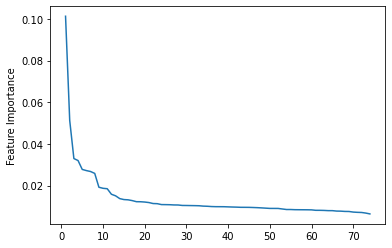

In [45]:
feature_importance_sum = [sum(feature_df['Feature Importance'][0: foo+1]) for foo in range(0, len(feature_df['Feature Importance']))]

_ = sns.lineplot(x=range(1, len(feature_df['Feature Importance']) + 1), y=feature_df['Feature Importance'])


The above graph shows list of features from highest important to low and how the graph traverses downwards.  At about 10th estimate we see a very slow decrease .

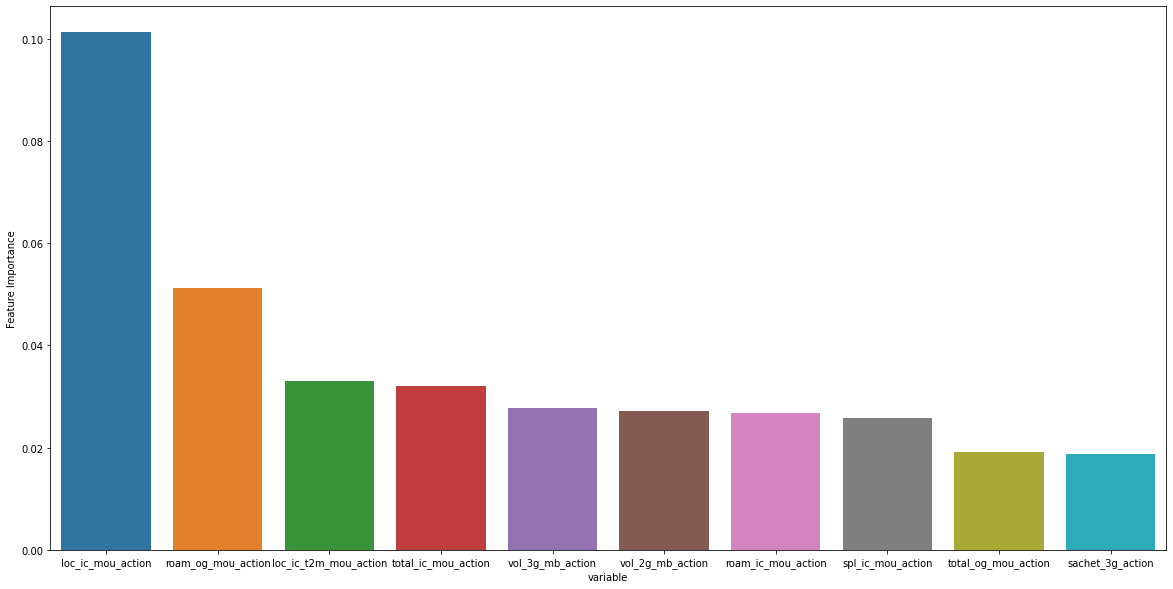

In [46]:
plt.figure(figsize=(20,10))
_ = sns.barplot(x=feature_df['variable'][:10], y=feature_df['Feature Importance'][:10])

##### Top 10 feature of importance are

In [52]:
display(feature_df.head(10))

,variable,Feature Importance
41,loc_ic_mou_action,0.101296
7,roam_og_mou_action,0.051288
37,loc_ic_t2m_mou_action,0.032997
51,total_ic_mou_action,0.032043
65,vol_3g_mb_action,0.027784
63,vol_2g_mb_action,0.027223
5,roam_ic_mou_action,0.026775
53,spl_ic_mou_action,0.025873
33,total_og_mou_action,0.019229
73,sachet_3g_action,0.018720


###### Some suggestion to keep the churn rate in control are
1. Keep vigil on the action phase i.e the current month , since the top 10 attributes are of of the same period.
2. Churn is highly impacted by user activity on local incoming calls in action month
3. Vol of 2g and 3g usage plays an important role in churn prediction . Ensuring better netowrk connectivity and higher bandwidth `can lead to` more volume consumption and hence lower churn.
4. Minutes of usage in both incoming and outgoing call plays an important role . Ensuring lower call drops and plans for higher minute usage can also lead to lower churn
5. Roaming minutes of usage for both incoming and outgoing are among the top 10 features of importance . Ensuring conditions that lead to higher usage like lower drop rates , free talktime plan etc can help out a lot.
6. sachet_3g_action i.e 3g plan with sachet scheme is also a point of good importance here. 

The commented line below thorws out a txt file . Analyzing it shows that none of sign is ">" , i.e higher value in the important predictor will mostly lead to lower churn.

In [47]:
#gs.best_estimator_.get_booster().dump_model("out.txt")

#### Final Outcomes
1. ##### For predicting churn user

    1. `Logisitc Regression -> LogisticRegression with 'saga' as solver , l2 regularization and random state as 100`
    2. PCA Components - `20`
    3. SMOTE for subsampling with `k_neighbors 5`
    4. Test Recall is approximately 79%
    
    
2. ##### For Predicting important variables

    1. UnderSampling with RUS
    2. Classifying using XGBClassifier 
    3. param_model__max_depth - 10
    4. param_model__n_estimators - 1400
    5. param_subsample - 0.8
    6. Recall rate is `80.83%`
    7. Top 10 Variables of importance
    
        1. loc_ic_mou_action	0.101296
        2. roam_og_mou_action	0.051288
        3. loc_ic_t2m_mou_action	0.032997
        4. total_ic_mou_action	0.032043
        5. vol_3g_mb_action	0.027784
        6. vol_2g_mb_action	0.027223
        7. roam_ic_mou_action	0.026775
        8. spl_ic_mou_action	0.025873
        9. total_og_mou_action	0.019229
        10. sachet_3g_action	0.018720
        
3.  ###### Some suggestion to keep the churn rate in control are
    1. Keep vigil on the action phase i.e the current month , since the top 10 attributes are of of the same period.
    2. Churn is highly impacted by user activity on local incoming calls in action month
    3. Vol of 2g and 3g usage plays an important role in churn prediction . Ensuring better netowrk connectivity and higher bandwidth `can lead to` more volume consumption and hence lower churn.
    4. Minutes of usage in both incoming and outgoing call plays an important role . Ensuring lower call drops and plans for higher minute usage can also lead to lower churn
    5. Roaming minutes of usage for both incoming and outgoing are among the top 10 features of importance . Ensuring conditions that lead to higher usage like lower drop rates , free talktime plan etc can help out a lot.
    6. sachet_3g_action i.e 3g plan with sachet scheme is also a point of good importance here. 
  